# CS 4644: The Perceptrons

## Part 1: Setup

##### STEP 1: Mount Google Drive and Set Device for Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_path = "drive/MyDrive" # NOTE: Separated so that colab can access the '.kaggle' folder in your Google Drive for Kaggle API authentication
project_folder = drive_path + "/CS4644_FinalProject"

##### STEP 2: All Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms, models
from PIL import Image

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
from keras import layers
from keras import models
from keras import backend as K
from tensorflow.keras.utils import to_categorical

##### STEP 3: Seed for Reproducability

In [ ]:
SEED = 8
np.random.seed(SEED)
torch.manual_seed(SEED)

##### STEP 4: General Helper Functions

In [ ]:
def loss_valid_comp(loss, accuracy, epochs, prefix='Training'):
  fig, ax = plt.subplots()

  # Plot Loss
  ax.set_xlabel('Epoch')
  ax.set_ylabel(' '.join([prefix,'Loss (%)']), color='tab:red')
  ax.plot(epochs, loss * 100, color='tab:red', label=' '.join([prefix,'Loss']))
  ax.tick_params(axis='y', labelcolor='tab:red')

  # Plot Validation Accuracy
  ax = ax.twinx()
  ax.set_xlabel('Epoch')
  ax.set_ylabel(' '.join([prefix,'Accuracy (%)']), color='tab:blue')
  ax.plot(epochs, accuracy * 100, color='tab:blue', label=' '.join([prefix,'Accuracy']))
  ax.tick_params(axis='y', labelcolor='tab:blue')

  # Title and Layout
  plt.suptitle(' '.join([prefix,'Loss and Accuracy Percentages over Epochs']))
  fig.tight_layout()

  # Show plot
  plt.show()

In [ ]:
def model_comparison(model1_name, model1_loss, model1_accuracy, model2_name, model2_loss, model2_accuracy, prefix="Training"):

  loss_diff = abs(model1_loss - model2_loss)
  val_diff = abs(model1_accuracy - model2_accuracy)
  print("Loss Difference:\n", loss_diff)
  print("Max Loss Difference:", max(loss_diff))
  print("Accuracy Difference:\n", val_diff)
  print("Max Accuracy Difference:", max(val_diff))

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(model1_loss, label=' '.join([model1_name, prefix, 'Loss']))
  plt.plot(model2_loss, label=' '.join([model2_name, prefix, 'Loss']))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title(' '.join([model1_name, 'vs.', model2_name, 'Loss Curves']))

  plt.subplot(1, 2, 2)
  plt.plot(model1_accuracy, label=' '.join([model1_name, prefix, 'Accuracy']))
  plt.plot(model2_accuracy, label=' '.join([model2_name, prefix, 'Accuracy']))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title(' '.join([model1_name, 'vs.', model2_name, 'Accuracy Curves']))

  plt.tight_layout()
  plt.show()

In [ ]:
def train_torch(model, optimizer=None, criterion = nn.BCEWithLogitsLoss(), learning_rate=1e-4):
  model.to(DEVICE)

  if not optimizer:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  train_accuracies = []

  val_losses = []
  val_accuracies = []

  for epoch in range(EPOCHS):

      model.train()

      train_correct = 0
      train_total = 0
      train_running_loss = 0.0

      for imgs, labels in train_loader:

          # STEP: Send tensors to device
          imgs = imgs.to(DEVICE)
          labels = labels.float().unsqueeze(1).to(DEVICE)

          optimizer.zero_grad()

          outputs = model(imgs)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

          # STEP: Calculate training loss
          train_running_loss += loss.item()

          # STEP: Calculate training accuracy
          predictions = torch.sigmoid(outputs).round()
          train_correct += (predictions.squeeze() == labels.squeeze()).sum().item()
          train_total += labels.size(0)

      # STEP: Calculate average training metrics
      avg_train_loss = train_running_loss / len(train_loader)
      train_losses.append(avg_train_loss)

      avg_train_acc = train_correct / train_total
      train_accuracies.append(avg_train_acc)



      model.eval()

      val_correct = 0
      val_total = 0
      val_running_loss = 0.0

      with torch.no_grad():
          for imgs, labels in val_loader:
              # STEP: Send tensors to device
              imgs = imgs.to(DEVICE)
              labels = labels.float().unsqueeze(1).to(DEVICE)

              outputs = model(imgs)

              # STEP: Calculate validation loss
              val_loss = criterion(outputs, labels)
              val_running_loss += val_loss.item()

              # STEP: Calculate validation accuracy
              predictions = torch.sigmoid(outputs).round()
              val_correct += (predictions.squeeze() == labels.squeeze()).sum().item()
              val_total += labels.size(0)

      # STEP: Calculate average validation metrics
      avg_val_loss = val_running_loss / len(val_loader)
      val_losses.append(avg_val_loss)

      avg_val_acc = val_correct / val_total
      val_accuracies.append(avg_val_acc)



      # STEP: Output Progress
      print(f"Epoch {epoch+1}/{EPOCHS} — accuracy: {avg_train_acc:.4f} - loss: {avg_train_loss:.4f} - val_accuracy {avg_val_acc:.4f} - val_loss: {avg_val_loss:.4f}")\

  return train_losses, train_accuracies, val_losses, val_accuracies

## PART 2: Load the Datasets

In [ ]:
def zip_to_colab(zip_file_path, extract_dir_name):
  extract_dir = '/content/' + extract_dir_name + "/"
  os.makedirs(extract_dir, exist_ok=True)
  before_file_count = len(os.listdir(extract_dir))

  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)

  files_extracted = len(os.listdir(extract_dir)) - before_file_count
  print(f"Files from {zip_file_path} extracted to: {extract_dir}")
  print("Number of files extracted:", files_extracted)
  return files_extracted

##### STEP 1: Load the "Human Faces" Dataset

Dataset Source: ["Human Faces" by Ashwin Gupta](https://www.kaggle.com/datasets/ashwingupta3012/human-faces/data)

In [ ]:
# zip_to_colab(project_folder + '/HumanFacesCleaned.zip', "HumanFacesImages")
# HUMANFACES_IMAGE_EXTENSIONS = {'.png', '.JPG', '.jpeg', '.jpg'}

##### STEP 2: Load the "Fake-Vs-Real-Faces (Hard)" Dataset

Dataset Source: ["Fake-Vs-Real-Faces (Hard)" by Hamza Boulahi](https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces)

In [ ]:
file_count = zip_to_colab(project_folder + '/RealImages.zip', 'FakeVsRealFacesImages')
file_count += zip_to_colab(project_folder + '/FakeImages.zip', 'FakeVsRealFacesImages')
assert len(os.listdir('/content/FakeVsRealFacesImages/')) == file_count # Check to make sure no files were overridden

Files from drive/MyDrive/CS4644_FinalProject/RealImages.zip extracted to: /content/FakeVsRealFacesImages/
Number of files extracted: 589
Files from drive/MyDrive/CS4644_FinalProject/FakeImages.zip extracted to: /content/FakeVsRealFacesImages/
Number of files extracted: 700


In [ ]:
FAKEVREAL_IMAGE_EXTENSIONS = {'.jpg'}
FAKEVREAL_IMAGE_PATH = '/content/FakeVsRealFacesImages/'

## PART 3: Separate Data Into Test and Train Sets

In [ ]:
def inspect_df(dataframe, rows=10):
  count_real = dataframe[dataframe['label'] == 1].shape[0]
  count_fake = dataframe[dataframe['label'] == 0].shape[0]
  assert count_real + count_fake == dataframe.shape[0]
  print("# of Real Images:", count_real)
  print("# of Fake Images:", count_fake)
  print("% Real:", (100 * count_real) // dataframe.shape[0])
  print("% Fake:", (100 * count_fake) // dataframe.shape[0])
  return dataframe.sample(frac=1, random_state=SEED).head(rows)

Step 1: Load the dataset labels into a dataframe.

In [ ]:
df_RealVFake = pd.read_csv(project_folder + "/RealVFakeLabels.csv")
df_RealVFake.head(10)

,images_id,label
0,real_1,real
1,real_10,real
2,real_100,real
3,real_101,real
4,real_102,real
5,real_103,real
6,real_104,real
7,real_105,real
8,real_106,real
9,real_107,real


STEP 2: Replace the 'real' and 'fake' labelings with 1 and 0 respectively.

In [ ]:
df_RealVFake.loc[df_RealVFake['label'] == 'real', 'label'] = 1
df_RealVFake.loc[df_RealVFake['label'] == 'fake', 'label'] = 0
inspect_df(df_RealVFake)

# of Real Images: 589
# of Fake Images: 700
% Real: 45
% Fake: 54


,images_id,label
1123,fake_580,0
1265,fake_78,0
385,real_446,1
955,fake_429,0
437,real_493,1
230,real_306,1
1107,fake_566,0
688,fake_189,0
111,real_2,1
223,real_30,1


STEP 3: Randomly separate the rows into an 80% test set and a 20% train set.

In [ ]:
# Shuffle Dataset
df_RealVFake_shuffled = df_RealVFake.sample(frac=1, random_state=SEED)

# Calculate the split index
separation_idx = int(0.8 * len(df_RealVFake_shuffled))

# Split data into train and test sets
df_train_RealVFake = df_RealVFake_shuffled[:separation_idx]
df_test_RealVFake = df_RealVFake_shuffled[separation_idx:]

print("Train set shape:", df_train_RealVFake.shape)
print("Test set shape:", df_test_RealVFake.shape)

Train set shape: (1031, 2)
Test set shape: (258, 2)


In [ ]:
inspect_df(df_train_RealVFake)

# of Real Images: 470
# of Fake Images: 561
% Real: 45
% Fake: 54


,images_id,label
1097,fake_557,0
225,real_301,1
1260,fake_73,0
857,fake_340,0
468,real_520,1
1095,fake_555,0
232,real_308,1
292,real_362,1
1104,fake_563,0
640,fake_145,0


In [ ]:
inspect_df(df_test_RealVFake)

# of Real Images: 119
# of Fake Images: 139
% Real: 46
% Fake: 53


,images_id,label
178,real_26,1
528,real_575,1
480,real_531,1
1105,fake_564,0
168,real_250,1
1167,fake_62,0
136,real_221,1
142,real_227,1
42,real_137,1
1038,fake_503,0


## PART 4: Define the Models

##### STEP 1: Reference Paper Keras Model

Original Paper Reference: https://philarchive.org/archive/SALCOR-3

In [ ]:
model_reference = models.Sequential()
model_reference.add(layers.Conv2D(32, (3, 3), activation='relu',
  input_shape=(256, 256, 3)))
model_reference.add(layers.MaxPooling2D((2, 2)))
model_reference.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_reference.add(layers.MaxPooling2D((2, 2)))
model_reference.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_reference.add(layers.MaxPooling2D((2, 2)))
model_reference.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_reference.add(layers.MaxPooling2D((2, 2)))
model_reference.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_reference.add(layers.MaxPooling2D((2, 2)))
model_reference.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_reference.add(layers.MaxPooling2D((2, 2)))
model_reference.add(layers.Flatten())
model_reference.add(layers.Dense(512, activation='relu'))
model_reference.add(layers.Dense(2, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### STEP 2: Keras Model Optimizations

**Model 1**

Optimizations:


*   Add transformations to the model's data



In [ ]:
keras_moreTransforms = models.Sequential()
keras_moreTransforms.add(layers.Conv2D(32, (3, 3), activation='relu',
  input_shape=(256, 256, 3)))
keras_moreTransforms.add(layers.MaxPooling2D((2, 2)))
keras_moreTransforms.add(layers.Conv2D(64, (3, 3), activation='relu'))
keras_moreTransforms.add(layers.MaxPooling2D((2, 2)))
keras_moreTransforms.add(layers.Conv2D(128, (3, 3), activation='relu'))
keras_moreTransforms.add(layers.MaxPooling2D((2, 2)))
keras_moreTransforms.add(layers.Conv2D(256, (3, 3), activation='relu'))
keras_moreTransforms.add(layers.MaxPooling2D((2, 2)))
keras_moreTransforms.add(layers.Conv2D(256, (3, 3), activation='relu'))
keras_moreTransforms.add(layers.MaxPooling2D((2, 2)))
keras_moreTransforms.add(layers.Conv2D(512, (3, 3), activation='relu'))
keras_moreTransforms.add(layers.MaxPooling2D((2, 2)))
keras_moreTransforms.add(layers.Flatten())
keras_moreTransforms.add(layers.Dense(512, activation='relu'))
keras_moreTransforms.add(layers.Dense(2, activation='softmax'))

##### STEP 3: PyTorch Conversion

Convert the Reference Paper Keras Model to PyTorch

In [ ]:
# The Reference Model Converted

conv2d_ks = 3 # Conv2d Kernel Size
conv2d_pad = 1 # Conv2d Padding
conv2d_s = 1 # Conv2d Stride

maxpool2d_ks = 2 # MaxPool2d Kernel Size
maxpool2d_s = 2 # MaxPool2d Stride

model_pytorch_conversion = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=conv2d_ks, padding=conv2d_pad, stride=conv2d_s),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=maxpool2d_ks, stride=maxpool2d_s),
    nn.Conv2d(32, 64, kernel_size=conv2d_ks, padding=conv2d_pad, stride=conv2d_s),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=maxpool2d_ks, stride=maxpool2d_s),
    nn.Conv2d(64, 128, kernel_size=conv2d_ks, padding=conv2d_pad, stride=conv2d_s),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=maxpool2d_ks, stride=maxpool2d_s),
    nn.Conv2d(128, 256, kernel_size=conv2d_ks, padding=conv2d_pad, stride=conv2d_s),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=maxpool2d_ks, stride=maxpool2d_s),
    nn.Conv2d(256, 256, kernel_size=conv2d_ks, padding=conv2d_pad, stride=conv2d_s),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=maxpool2d_ks, stride=maxpool2d_s),
    nn.Conv2d(256, 512, kernel_size=conv2d_ks, padding=conv2d_pad, stride=conv2d_s),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=maxpool2d_ks, stride=maxpool2d_s),
    nn.Flatten(),
    nn.Linear(8192, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
)

##### STEP 4: PyTorch Model Optimizations

We optimize the PyTorch Conversion model to achieve better scores and classify images as real or fake, and then classify the fake images as synthetic or deepfake.

**Model 1**

Optimizations:


*   List item
*   List item



**Model 2**

Optimizations:

*   List item
*   List item


**Model 3**

Optimizations:

*   List item
*   List item

## PART 5: Establishing the Baseline

Goal: Confirm that the Keras Model and PyTorch Conversion have the same accuracy on both the test and train set.

In [ ]:
IMG_SIZE = 256
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def basic_process_data(dataset, path):
    keras_data = []
    torch_data = []
    labels = []

    for _, row in dataset.iterrows():
        image_path = ''.join([path, row["images_id"], '.jpg'])

        try:
            img = Image.open(image_path).resize((256,256))
            img = np.array(img) / 255.0
            keras_data.append(img)
            img = torch.FloatTensor(img).permute(2, 0, 1)
            torch_data.append(img)
            labels.append(row["label"])

        except Exception as e:
            print(f"Error loading or processing image {image_path}: {e}")

    num_classes = len(set(labels))
    torch_labels = torch.tensor(labels, dtype=torch.float32).squeeze(0).to(DEVICE)
    torch_data = torch.stack(torch_data).to(DEVICE)

    return np.array(keras_data), to_categorical(np.array(labels), num_classes=num_classes), torch_data, torch_labels

In [ ]:
fakeVReal_TrainData, fakeVReal_TrainLabels, fakeVReal_TrainData_T, fakeVReal_TrainLabels_T = basic_process_data(df_train_RealVFake, FAKEVREAL_IMAGE_PATH)
fakeVReal_TestData, fakeVReal_TestLabels, fakeVReal_TestData_T, fakeVReal_TestLabels_T = basic_process_data(df_test_RealVFake, FAKEVREAL_IMAGE_PATH)

##### STEP 1: Train the Base Keras Model

In [ ]:
model_reference.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model_reference_results = model_reference.fit(fakeVReal_TrainData, fakeVReal_TrainLabels, epochs=EPOCHS, validation_data=(fakeVReal_TestData, fakeVReal_TestLabels))
model_reference_history = pd.DataFrame(model_reference_results.history)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.5015 - loss: 0.7015 - val_accuracy: 0.5388 - val_loss: 0.6924
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.5611 - loss: 0.6920 - val_accuracy: 0.5426 - val_loss: 0.6811
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6856 - loss: 0.5862 - val_accuracy: 0.8953 - val_loss: 0.2513
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9424 - loss: 0.1486 - val_accuracy: 0.9845 - val_loss: 0.0449
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.9891 - loss: 0.0313 - val_accuracy: 0.9884 - val_loss: 0.0402
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9962 - loss: 0.0103 - val_accuracy: 0.9922 - val_loss: 0.0462
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9951 - loss: 0.0061 - val_accuracy: 0.9884 - val_loss: 0.0251
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9990 - loss: 0.0029 - val_accuracy: 0.9961 -

In [ ]:
model_reference_results.history

{'accuracy': [0.5286129713058472,
  0.5460717678070068,
  0.7487875819206238,
  0.9602327942848206,
  0.9922405481338501,
  0.9941803812980652,
  0.997090220451355,
  0.9990300536155701,
  1.0,
  1.0],
 'loss': [0.6942375898361206,
  0.6916074156761169,
  0.5070012211799622,
  0.11541995406150818,
  0.026635823771357536,
  0.01502735260874033,
  0.005653710570186377,
  0.0031331495847553015,
  0.0003144029469694942,
  7.367113721556962e-05],
 'val_accuracy': [0.538759708404541,
  0.5426356792449951,
  0.895348846912384,
  0.9844961166381836,
  0.9883720874786377,
  0.9922480583190918,
  0.9883720874786377,
  0.9961240291595459,
  0.9883720874786377,
  0.9883720874786377],
 'val_loss': [0.6923757195472717,
  0.6810609102249146,
  0.25125837326049805,
  0.04485376179218292,
  0.04022824019193649,
  0.04617161303758621,
  0.02512970194220543,
  0.010362314991652966,
  0.025299230590462685,
  0.026459326967597008]}

In [ ]:
model_reference_history.to_csv(''.join(['/content/', project_folder, "/model_reference_history.csv"]))
model_reference_history

,accuracy,loss,val_accuracy,val_loss
0,0.528613,0.694238,0.538760,0.692376
1,0.546072,0.691607,0.542636,0.681061
2,0.748788,0.507001,0.895349,0.251258
3,0.960233,0.115420,0.984496,0.044854
4,0.992241,0.026636,0.988372,0.040228
5,0.994180,0.015027,0.992248,0.046172
6,0.997090,0.005654,0.988372,0.025130
7,0.999030,0.003133,0.996124,0.010362
8,1.000000,0.000314,0.988372,0.025299
9,1.000000,0.000074,0.988372,0.026459


In [ ]:
model_reference.save(''.join(['/content/', project_folder, "/model_reference.keras"]))

##### STEP 2: Train the Base PyTorch Conversion Model

In [ ]:
BATCH_SIZE = 32
LR = 1e-4

GENERATOR = torch.Generator()
GENERATOR.manual_seed(SEED)

In [ ]:
train_dataset = torch.utils.data.TensorDataset(fakeVReal_TrainData_T, fakeVReal_TrainLabels_T)
test_dataset = torch.utils.data.TensorDataset(fakeVReal_TestData_T, fakeVReal_TestLabels_T)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=GENERATOR)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
pytorch_conversion_train_losses, pytorch_conversion_train_accuracies, pytorch_conversion_val_losses, pytorch_conversion_val_accuracies = train_torch(model_pytorch_conversion, learning_rate=LR)

Epoch 1/10 — accuracy: 0.5354 - loss: 0.6914 - val_accuracy 0.5388 - val_loss: 0.6928
Epoch 2/10 — accuracy: 0.6285 - loss: 0.6428 - val_accuracy 0.8605 - val_loss: 0.4347
Epoch 3/10 — accuracy: 0.9146 - loss: 0.2057 - val_accuracy 0.9574 - val_loss: 0.0994
Epoch 4/10 — accuracy: 0.9767 - loss: 0.0668 - val_accuracy 0.9961 - val_loss: 0.0197
Epoch 5/10 — accuracy: 0.9913 - loss: 0.0262 - val_accuracy 1.0000 - val_loss: 0.0062
Epoch 6/10 — accuracy: 0.9961 - loss: 0.0105 - val_accuracy 1.0000 - val_loss: 0.0043
Epoch 7/10 — accuracy: 0.9990 - loss: 0.0030 - val_accuracy 0.9922 - val_loss: 0.0114
Epoch 8/10 — accuracy: 1.0000 - loss: 0.0019 - val_accuracy 1.0000 - val_loss: 0.0050
Epoch 9/10 — accuracy: 1.0000 - loss: 0.0007 - val_accuracy 1.0000 - val_loss: 0.0038
Epoch 10/10 — accuracy: 1.0000 - loss: 0.0005 - val_accuracy 1.0000 - val_loss: 0.0058


In [ ]:
pytorch_conversion_history = pd.DataFrame({
    'accuracy': pytorch_conversion_train_accuracies,
    'loss': pytorch_conversion_train_losses,
    'val_accuracy': pytorch_conversion_val_accuracies,
    'val_loss': pytorch_conversion_val_losses
})
pytorch_conversion_history.to_csv(''.join(['/content/', project_folder, "/pytorch_conversion_history.csv"]))
pytorch_conversion_history

,accuracy,loss,val_accuracy,val_loss
0,0.535403,0.691394,0.538760,0.692777
1,0.628516,0.642838,0.860465,0.434692
2,0.914646,0.205699,0.957364,0.099390
3,0.976722,0.066830,0.996124,0.019714
4,0.991271,0.026186,1.000000,0.006194
5,0.996120,0.010459,1.000000,0.004348
6,0.999030,0.003039,0.992248,0.011440
7,1.000000,0.001915,1.000000,0.004969
8,1.000000,0.000711,1.000000,0.003801
9,1.000000,0.000538,1.000000,0.005806


In [ ]:
torch.save(model_pytorch_conversion.state_dict(), ''.join(['/content/', project_folder, "/pytorch_conversion.pth"]))

##### STEP 3: Baseline Visualizations

1. Keras Model Training and Validation

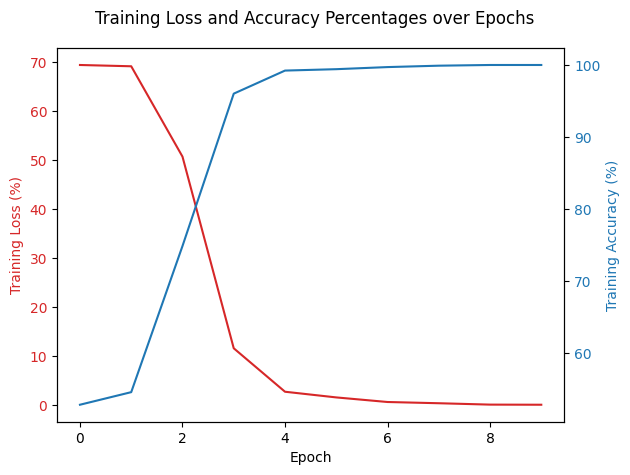

In [ ]:
loss_valid_comp(model_reference_history["loss"], model_reference_history["accuracy"], model_reference_results.epoch)

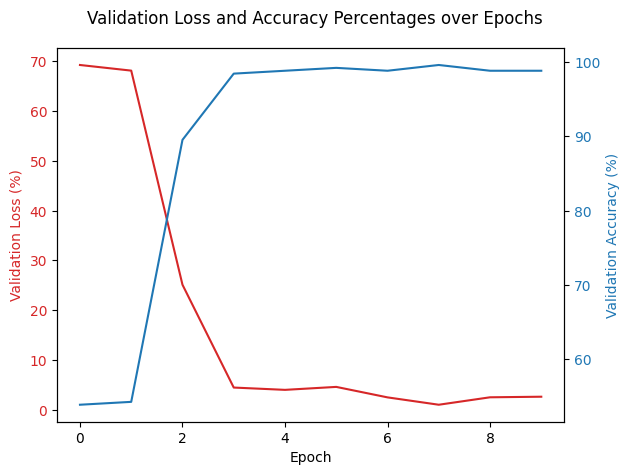

In [ ]:
loss_valid_comp(model_reference_history["val_loss"], model_reference_history["val_accuracy"], model_reference_results.epoch, prefix="Validation")

2. PyTorch Conversion Model Training and Validation

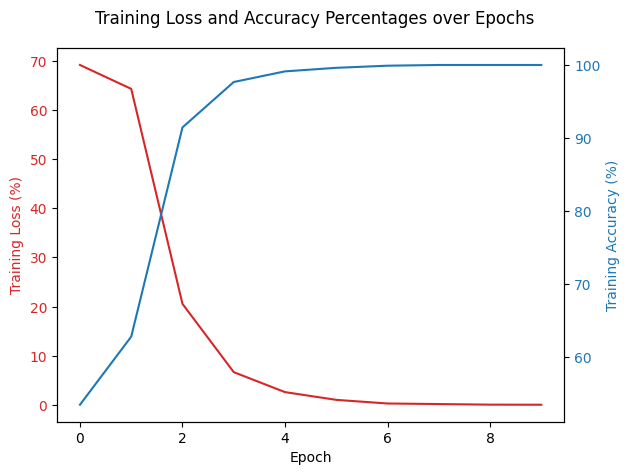

In [ ]:
loss_valid_comp(pytorch_conversion_history["loss"], pytorch_conversion_history["accuracy"], model_reference_results.epoch)

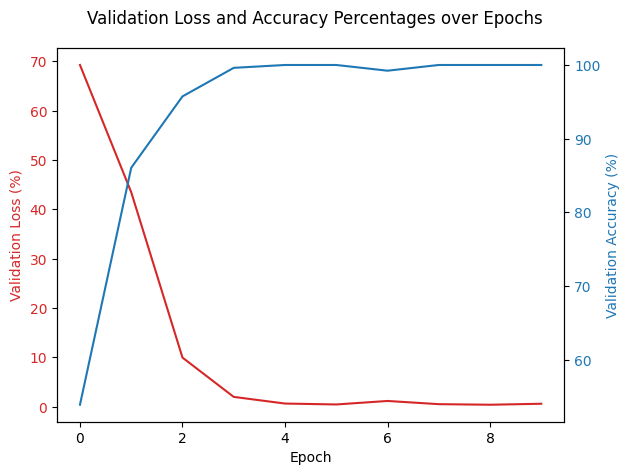

In [ ]:
loss_valid_comp(pytorch_conversion_history["val_loss"], pytorch_conversion_history["val_accuracy"], model_reference_results.epoch, prefix="Validation")

##### STEP 4: Baseline Comparisons

Loss Difference:
 0    0.002844
1    0.048770
2    0.301302
3    0.048590
4    0.000450
5    0.004568
6    0.002614
7    0.001218
8    0.000396
9    0.000465
Name: loss, dtype: float64
Max Loss Difference: 0.3013022140543343
Accuracy Difference:
 0    0.006790
1    0.082444
2    0.165858
3    0.016489
4    0.000970
5    0.001940
6    0.001940
7    0.000970
8    0.000000
9    0.000000
Name: accuracy, dtype: float64
Max Accuracy Difference: 0.16585839286114146


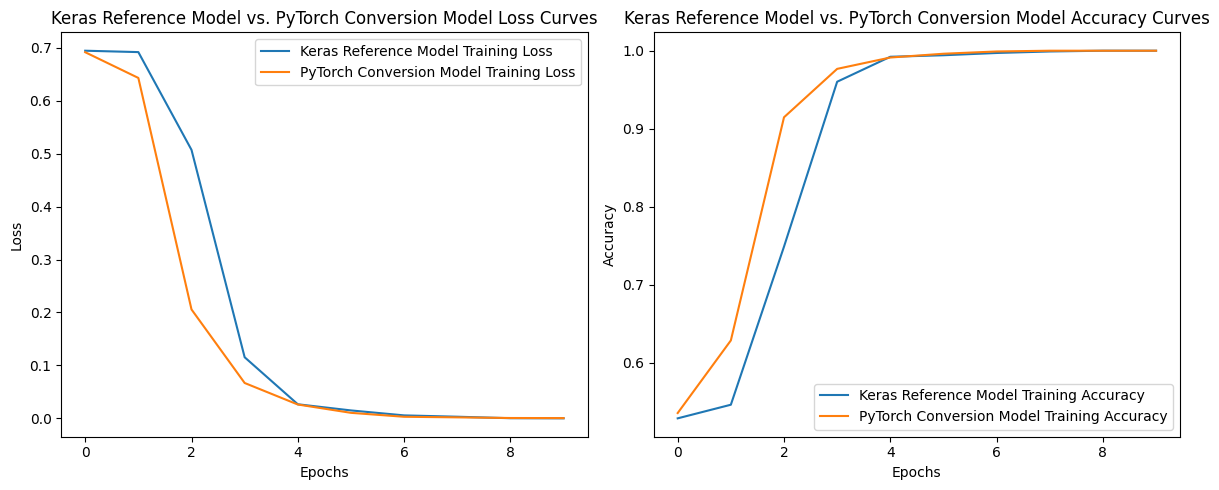

In [ ]:
model_comparison("Keras Reference Model", model_reference_history["loss"], model_reference_history["accuracy"], "PyTorch Conversion Model", pytorch_conversion_history["loss"], pytorch_conversion_history["accuracy"],)

Loss Difference:
 0    0.000401
1    0.246368
2    0.151868
3    0.025139
4    0.034035
5    0.041824
6    0.013690
7    0.005393
8    0.021498
9    0.020654
Name: val_loss, dtype: float64
Max Loss Difference: 0.2463684148258633
Accuracy Difference:
 0    1.848206e-08
1    3.178294e-01
2    6.201549e-02
3    1.162791e-02
4    1.162791e-02
5    7.751942e-03
6    3.875975e-03
7    3.875971e-03
8    1.162791e-02
9    1.162791e-02
Name: val_accuracy, dtype: float64
Max Accuracy Difference: 0.3178294370340746


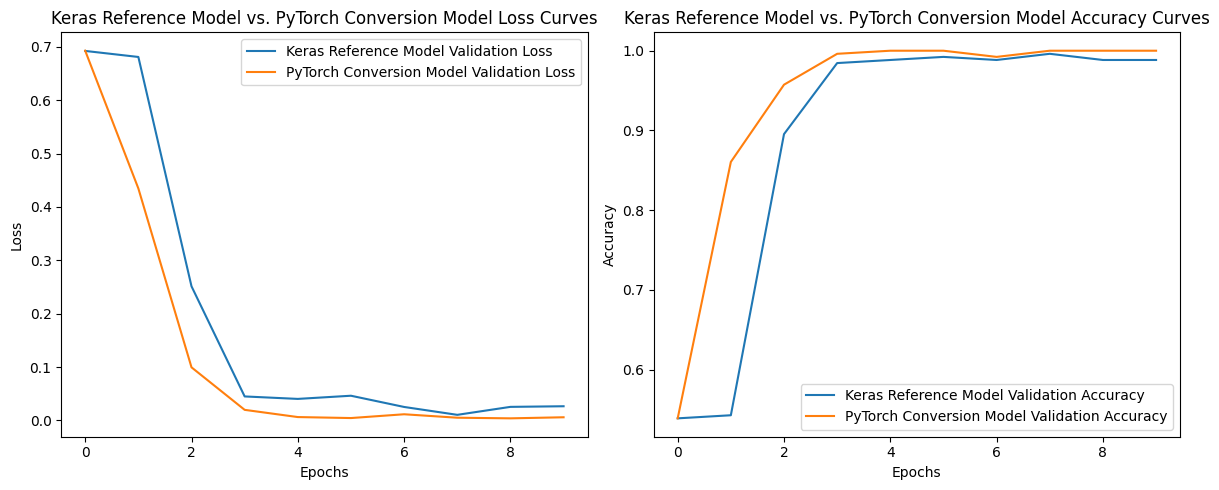

In [ ]:
model_comparison("Keras Reference Model", model_reference_history["val_loss"], model_reference_history["val_accuracy"], "PyTorch Conversion Model", pytorch_conversion_history["val_loss"], pytorch_conversion_history["val_accuracy"], prefix="Validation")

## PART 6: Original Keras vs. Optimized Models

##### STEP 1: vs. Model 1

In [ ]:
IMG_SIZE = 256
EPOCHS = 10

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [ ]:
def process_data_with_transforms(dataset, path):
    data = []
    labels = []

    for _, row in dataset.iterrows():
        image_path = ''.join([path, row["images_id"], '.jpg'])

        try:
            img = Image.open(image_path)
            img_tensor = transform(img)
            data.append(img_tensor.permute(1, 2, 0).numpy())
            labels.append(row["label"])

        except Exception as e:
            print(f"Error loading or processing image {image_path}: {e}")

    num_classes = len(set(labels))

    return np.array(data), to_categorical(np.array(labels), num_classes=num_classes)

In [ ]:
fakeVReal_TrainData, fakeVReal_TrainLabels = process_data_with_transforms(df_train_RealVFake, FAKEVREAL_IMAGE_PATH)
fakeVReal_TestData, fakeVReal_TestLabels = process_data_with_transforms(df_test_RealVFake, FAKEVREAL_IMAGE_PATH)

1. Training of Optimized Model 1

In [ ]:
keras_moreTransforms.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

keras_moreTransforms_results = keras_moreTransforms.fit(fakeVReal_TrainData, fakeVReal_TrainLabels, epochs=EPOCHS, validation_data=(fakeVReal_TestData, fakeVReal_TestLabels))
keras_moreTransforms_history = pd.DataFrame(keras_moreTransforms_results.history)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.5280 - loss: 0.8426 - val_accuracy: 0.5853 - val_loss: 0.6712
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6457 - loss: 0.6157 - val_accuracy: 0.8062 - val_loss: 0.4182
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8418 - loss: 0.3569 - val_accuracy: 0.9457 - val_loss: 0.1401
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9620 - loss: 0.1193 - val_accuracy: 0.9729 - val_loss: 0.0606
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9922 - loss: 0.0431 - val_accuracy: 0.9767 - val_loss: 0.0557
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9974 - loss: 0.0104 - val_accuracy: 0.9806 - val_loss: 0.0590
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9943 - loss: 0.0107 - val_accuracy: 0.9767 - val_loss: 0.0571
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9896 - loss: 0.0402 - val_accuracy: 0.9845 -

In [ ]:
keras_moreTransforms_results.history

{'accuracy': [0.6003879904747009,
  0.6973811984062195,
  0.8845781087875366,
  0.9573230147361755,
  0.9941803812980652,
  0.996120274066925,
  0.996120274066925,
  0.9903006553649902,
  0.997090220451355,
  0.9990300536155701],
 'loss': [0.7192031145095825,
  0.5623727440834045,
  0.2824668884277344,
  0.11977473646402359,
  0.027686264365911484,
  0.013096601702272892,
  0.01789148896932602,
  0.039556968957185745,
  0.009225341491401196,
  0.003678336273878813],
 'val_accuracy': [0.5852712988853455,
  0.8062015771865845,
  0.9457364082336426,
  0.9728682041168213,
  0.9767441749572754,
  0.9806201457977295,
  0.9767441749572754,
  0.9844961166381836,
  0.9844961166381836,
  0.9922480583190918],
 'val_loss': [0.6711845397949219,
  0.41819870471954346,
  0.1400601863861084,
  0.06055566668510437,
  0.05569955334067345,
  0.05900713428854942,
  0.05712193250656128,
  0.05790431797504425,
  0.046493321657180786,
  0.03360949456691742]}

In [ ]:
keras_moreTransforms_history.to_csv(''.join(['/content/', project_folder, "/model_reference_history_moreTransforms.csv"]))
keras_moreTransforms_history

,accuracy,loss,val_accuracy,val_loss
0,0.600388,0.719203,0.585271,0.671185
1,0.697381,0.562373,0.806202,0.418199
2,0.884578,0.282467,0.945736,0.140060
3,0.957323,0.119775,0.972868,0.060556
4,0.994180,0.027686,0.976744,0.055700
5,0.996120,0.013097,0.980620,0.059007
6,0.996120,0.017891,0.976744,0.057122
7,0.990301,0.039557,0.984496,0.057904
8,0.997090,0.009225,0.984496,0.046493
9,0.999030,0.003678,0.992248,0.033609


In [ ]:
keras_moreTransforms.save(''.join(['/content/', project_folder, "/keras_moreTransforms.keras"]))

2. Model Visualization

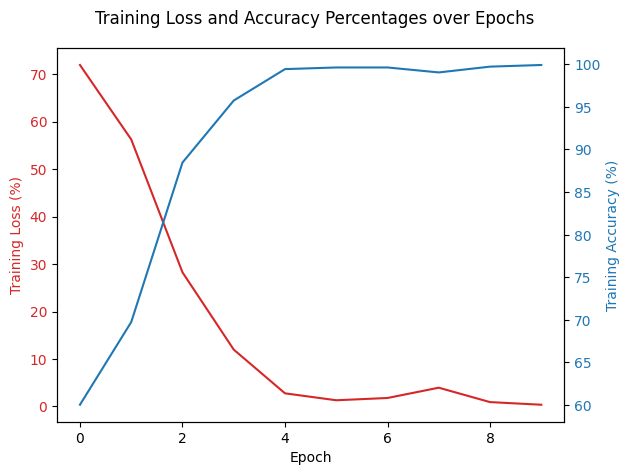

In [ ]:
loss_valid_comp(keras_moreTransforms_history["loss"], keras_moreTransforms_history["accuracy"], keras_moreTransforms_results.epoch)

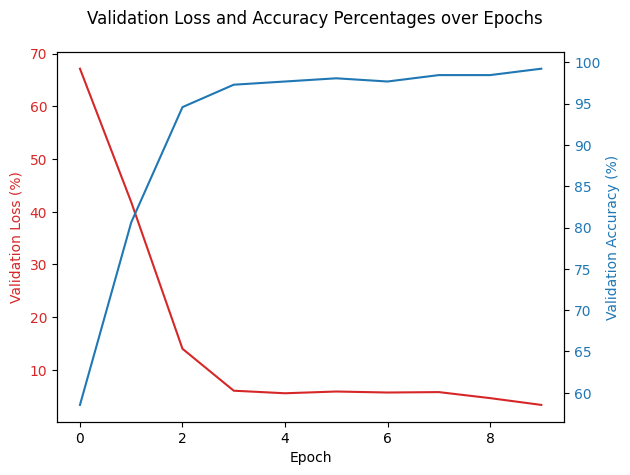

In [ ]:
loss_valid_comp(keras_moreTransforms_history["val_loss"], keras_moreTransforms_history["val_accuracy"], keras_moreTransforms_results.epoch, prefix="Validation")

3. Model Comparison with Keras Baseline

Loss Difference:
 0    0.024966
1    0.129235
2    0.224534
3    0.004355
4    0.001050
5    0.001931
6    0.012238
7    0.036424
8    0.008911
9    0.003605
Name: loss, dtype: float64
Max Loss Difference: 0.22453433275222778
Accuracy Difference:
 0    0.071775
1    0.151309
2    0.135791
3    0.002910
4    0.001940
5    0.001940
6    0.000970
7    0.008729
8    0.002910
9    0.000970
Name: accuracy, dtype: float64
Max Accuracy Difference: 0.15130943059921265


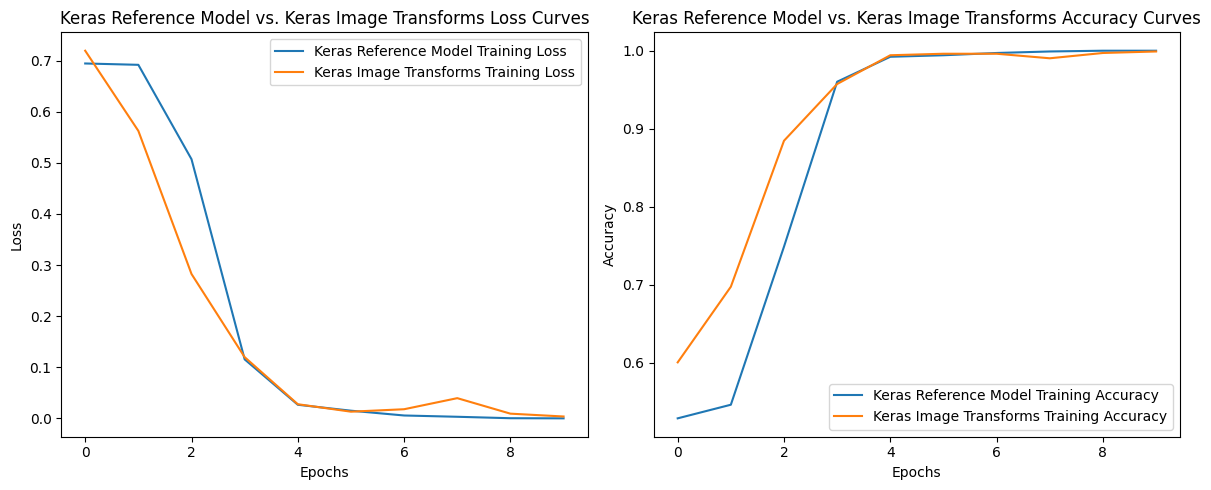

In [ ]:
model_comparison("Keras Reference Model", model_reference_history["loss"], model_reference_history["accuracy"], "Keras Image Transforms", keras_moreTransforms_history["loss"], keras_moreTransforms_history["accuracy"])

Loss Difference:
 0    0.021191
1    0.262862
2    0.111198
3    0.015702
4    0.015471
5    0.012836
6    0.031992
7    0.047542
8    0.021194
9    0.007150
Name: val_loss, dtype: float64
Max Loss Difference: 0.2628622055053711
Accuracy Difference:
 0    0.046512
1    0.263566
2    0.050388
3    0.011628
4    0.011628
5    0.011628
6    0.011628
7    0.011628
8    0.003876
9    0.003876
Name: val_accuracy, dtype: float64
Max Accuracy Difference: 0.26356589794158936


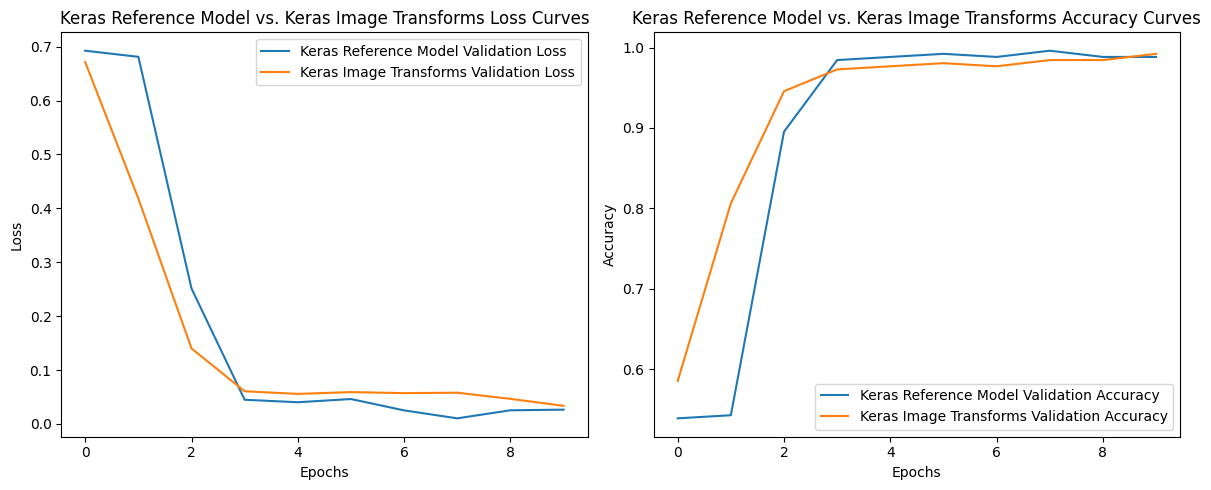

In [ ]:
model_comparison("Keras Reference Model", model_reference_history["val_loss"], model_reference_history["val_accuracy"], "Keras Image Transforms", keras_moreTransforms_history["val_loss"], keras_moreTransforms_history["val_accuracy"], prefix="Validation")

##### STEP 2: vs. Model 2

1. Training of Optimized Model 2

2. Visualization of Original PyTorch vs. Optimized Model 2

##### STEP 3: vs. Model 3

1. Training of Optimized Model 3

2. Visualization of Original PyTorch vs. Optimized Model 3

## PART 7: Original PyTorch vs. Optimized Models

##### STEP 1: vs. Model 1

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [ ]:
from tensorflow.keras.utils import to_categorical

def process_data(dataset, path):
    data = []
    labels = []

    for _, row in dataset.iterrows():
        image_path = ''.join([path, row["images_id"], '.jpg'])

        try:
            img = Image.open(image_path)
            img_tensor = transform(img)
            data.append(img_tensor.permute(1, 2, 0).numpy())
            labels.append(row["label"])

        except Exception as e:
            print(f"Error loading or processing image {image_path}: {e}")

    num_classes = len(set(labels))

    return np.array(data), to_categorical(np.array(labels), num_classes=num_classes)

In [ ]:
train_loader = DataLoader(list(df_train_RealVFake.itertuples(index=False)), batch_size=BATCH_SIZE, shuffle=True, generator=GENERATOR)
val_loader = DataLoader(list(df_test_RealVFake.itertuples(index=False)), batch_size=BATCH_SIZE, shuffle=False)

1. Training of Optimized Model 1

In [ ]:
model_reference.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model_reference_results = model_reference.fit(fakeVReal_TrainData, fakeVReal_TrainLabels, epochs=EPOCHS, validation_data=(fakeVReal_TestData, fakeVReal_TestLabels))
model_reference_history = pd.DataFrame(model_reference_results.history)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.5813 - loss: 0.8025 - val_accuracy: 0.6705 - val_loss: 0.5248
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.7515 - loss: 0.4435 - val_accuracy: 0.9651 - val_loss: 0.1117
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9685 - loss: 0.0913 - val_accuracy: 0.9767 - val_loss: 0.0810
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9889 - loss: 0.0287 - val_accuracy: 0.9651 - val_loss: 0.0850
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9935 - loss: 0.0312 - val_accuracy: 0.9806 - val_loss: 0.0670
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9971 - loss: 0.0211 - val_accuracy: 0.9767 - val_loss: 0.1322
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9727 - loss: 0.0687 - val_accuracy: 0.9767 - val_loss: 0.1942
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9932 - loss: 0.0178 - val_accuracy: 0.9651 -

In [ ]:
model_reference_results.history

{'accuracy': [0.6343355774879456,
  0.8205625414848328,
  0.9602327942848206,
  0.9893307685852051,
  0.9912706017494202,
  0.9980601072311401,
  0.9854510426521301,
  0.9864209294319153,
  0.9883608222007751,
  0.9951503276824951],
 'loss': [0.6839169859886169,
  0.3619377613067627,
  0.10733123868703842,
  0.04231804236769676,
  0.03362250328063965,
  0.011782253161072731,
  0.039623185992240906,
  0.04709678143262863,
  0.04903051629662514,
  0.014351658523082733],
 'val_accuracy': [0.6705426573753357,
  0.9651162624359131,
  0.9767441749572754,
  0.9651162624359131,
  0.9806201457977295,
  0.9767441749572754,
  0.9767441749572754,
  0.9651162624359131,
  0.9767441749572754,
  0.9883720874786377],
 'val_loss': [0.5247946977615356,
  0.11165475100278854,
  0.08098664879798889,
  0.08503235131502151,
  0.067027747631073,
  0.13218361139297485,
  0.19421136379241943,
  0.20809786021709442,
  0.0748814269900322,
  0.0523395761847496]}

In [ ]:
model_reference_history.to_csv(''.join(['/content/', project_folder, "/model_reference_history_moreTransforms.csv"]))
model_reference_history

,accuracy,loss,val_accuracy,val_loss
0,0.634336,0.683917,0.670543,0.524795
1,0.820563,0.361938,0.965116,0.111655
2,0.960233,0.107331,0.976744,0.080987
3,0.989331,0.042318,0.965116,0.085032
4,0.991271,0.033623,0.980620,0.067028
5,0.998060,0.011782,0.976744,0.132184
6,0.985451,0.039623,0.976744,0.194211
7,0.986421,0.047097,0.965116,0.208098
8,0.988361,0.049031,0.976744,0.074881
9,0.995150,0.014352,0.988372,0.052340


2. Visualization of Original PyTorch vs. Optimized Model 1

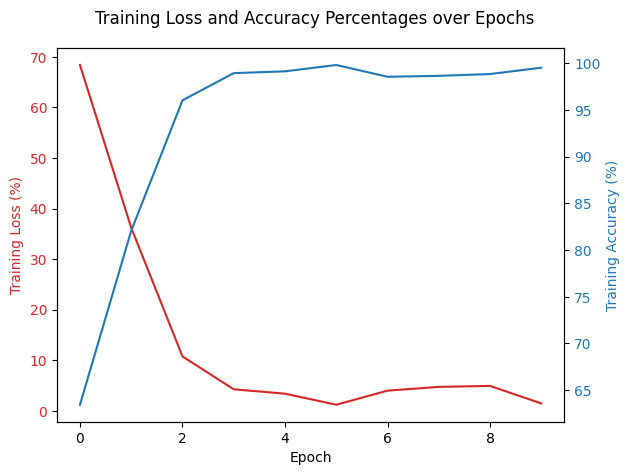

In [ ]:
loss_valid_comp(model_reference_history["loss"], model_reference_history["accuracy"], model_reference_results.epoch)

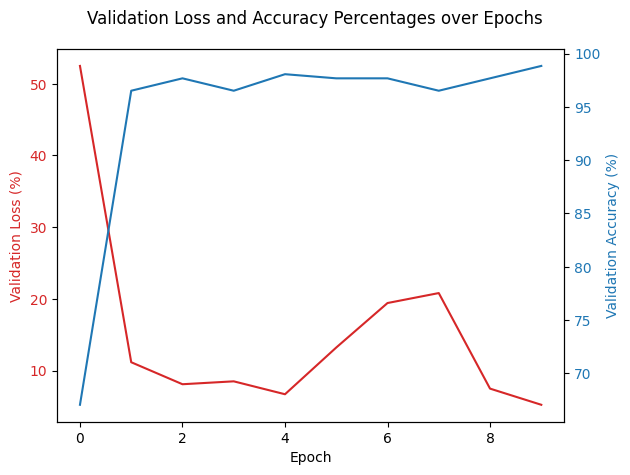

In [ ]:
loss_valid_comp(model_reference_history["val_loss"], model_reference_history["val_accuracy"], model_reference_results.epoch, prefix="Validation")

##### STEP 2: vs. Model 2

1. Training of Optimized Model 2

2. Visualization of Original PyTorch vs. Optimized Model 2

##### STEP 3: vs. Model 3

1. Training of Optimized Model 3

2. Visualization of Original PyTorch vs. Optimized Model 3

## PART 8: Keras vs. PyTorch

##### STEP 1: Model 1 Comparison

##### STEP 2: Model 2 Comparison

##### STEP 3: Model 4 Comparison

## References

1. https://towardsdatascience.com/efficiently-iterating-over-rows-in-a-pandas-dataframe-7dd5f9992c01/